# Data analytics final project

*Dominik Woźniak, 2022*

## Dataset
Dataset basing on golf putting data, typed in from Don Berry’s 1996 textbook. The columns are distance in feet from the hole, number of tries, and number of successes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,x,n,y
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149


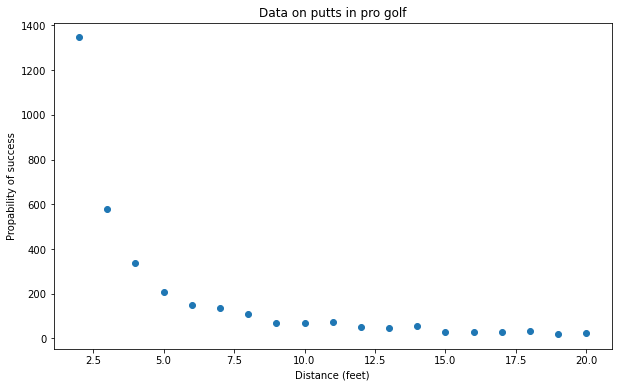

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(data.x, data.y)
plt.title('Data on putts in pro golf')
plt.xlabel('Distance (feet)')
plt.ylabel('Propability of success')
plt.show()

## Prepare data

In [5]:
import os
import json
from cmdstanpy import write_stan_json

In [6]:
from src.constants import DATA_DIR, STAN_INPUTS_DIR, RESULTS_DIR, SAMPLE_DIR, MEASUREMENTS_FILE, INPUT_PRIOR_FILE, INPUT_POSTERIOR_FILE
from src.helpers import get_stan_input, get_stan_inputs, prepare_data

In [7]:
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
    
if not os.path.exists(STAN_INPUTS_DIR):
    os.mkdir(STAN_INPUTS_DIR)    

In [8]:
prepared_data = prepare_data(data)

In [9]:
prepared_data.measurements.to_csv(MEASUREMENTS_FILE)

In [10]:
si_prior, si_posterior, sis_cv = get_stan_inputs(prepared_data)

In [11]:
write_stan_json(INPUT_POSTERIOR_FILE, si_posterior)
write_stan_json(INPUT_PRIOR_FILE, si_prior)

In [12]:
for i, stan_input in enumerate(sis_cv):
    file_path = os.path.join(STAN_INPUTS_DIR, f"split_{str(i)}.json")
    write_stan_json(file_path, stan_input)

In [13]:
with open(os.path.join(DATA_DIR, "coords.json"), "w") as f:
    json.dump(prepared_data.coords, f)

with open(os.path.join(DATA_DIR, "dims.json"), "w") as f:
    json.dump(prepared_data.dims, f)

## Model Sampling

In [14]:
from src.constants import STAN_DIR
from cmdstanpy import CmdStanModel
import arviz as az
from arviz.data.inference_data import InferenceData

In [76]:
LOGISTIC_MODEL = os.path.join(STAN_DIR, "logistic_model.stan")
STAN_INPUTS = sorted(os.listdir(STAN_INPUTS_DIR))
STAN_PRIOR_INPUT = os.path.join(DATA_DIR, "stan_input_prior.json")
STAN_POSTERIOR_INPUT = os.path.join(DATA_DIR, "stan_input_posterior.json")
PRIOR_FILE = os.path.join(SAMPLE_DIR, "prior.nc")
POSTERIOR_FILE = os.path.join(SAMPLE_DIR, "posterior.nc")

In [15]:
with open(os.path.join(DATA_DIR, "coords.json"), "r") as f:
    coords = json.load(f)

In [16]:
with open(os.path.join(DATA_DIR, "dims.json"), "r") as f:
    dims = json.load(f)

In [17]:
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

In [25]:
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)

In [19]:
kwargs = {'show_progress': True, 'save_warmup': False, 'iter_warmup': 1000, 'iter_sampling': 1000}

In [20]:
with open(STAN_PRIOR_INPUT, "r") as f:
        stan_prior_input = json.load(f)

In [33]:
with open(STAN_POSTERIOR_INPUT, "r") as f:
        stan_posterior_input = json.load(f)

In [34]:
coords["ix_train"] = [i - 1 for i in stan_prior_input["ix_train"]]
coords["ix_test"] = [i - 1 for i in stan_prior_input["ix_test"]]

In [35]:
model = CmdStanModel(
    stan_file=LOGISTIC_MODEL,
    stanc_options={'warn-pedantic': True},
)

INFO:cmdstanpy:found newer exe file, not recompiling


In [36]:
mcmc_prior = model.sample(data=STAN_PRIOR_INPUT, **kwargs)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [24]:
sampled_data = az.from_cmdstan(
    posterior=mcmc_prior.runset.csv_files,
    log_likelihood="llik",
    posterior_predictive="yrep",
    observed_data=STAN_PRIOR_INPUT,
    coords=coords,
    dims=dims,
)

In [27]:
sampled_data.to_netcdf(PRIOR_FILE)

'/Users/dominikwozniak/study/data_analytics/final/data/sample/prior.nc'

In [37]:
model = CmdStanModel(
    stan_file=LOGISTIC_MODEL,
    stanc_options={'warn-pedantic': True},
)

INFO:cmdstanpy:found newer exe file, not recompiling


In [38]:
coords["ix_train"] = [i - 1 for i in stan_posterior_input["ix_train"]]
coords["ix_test"] = [i - 1 for i in stan_posterior_input["ix_test"]]

In [39]:
mcmc_posterior = model.sample(data=STAN_POSTERIOR_INPUT, **kwargs)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [40]:
sampled_data = az.from_cmdstan(
    posterior=mcmc_prior.runset.csv_files,
    log_likelihood="llik",
    posterior_predictive="yrep",
    observed_data=STAN_POSTERIOR_INPUT,
    coords=coords,
    dims=dims,
)

In [41]:
sampled_data.to_netcdf(POSTERIOR_FILE)

'/Users/dominikwozniak/study/data_analytics/final/data/sample/posterior.nc'

In [45]:
if os.path.exists(PRIOR_FILE):
    prior = az.from_netcdf(PRIOR_FILE)
    
if os.path.exists(POSTERIOR_FILE):
    posterior = az.from_netcdf(POSTERIOR_FILE)

In [48]:
display(az.summary(prior))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.010,1.011,-1.926,1.896,0.017,0.016,3404.0,2659.0,1.0
b,0.008,1.026,-1.806,2.042,0.017,0.017,3660.0,2468.0,1.0


In [47]:
display(az.summary(posterior))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.011,1.016,-1.959,1.812,0.016,0.016,4030.0,2701.0,1.0
b,0.004,1.018,-1.967,1.859,0.016,0.018,3975.0,2807.0,1.0


In [52]:
a_mean = posterior.posterior["a"].mean()
b_mean = posterior.posterior["b"].mean()

In [65]:
from scipy.special import expit
from scipy.stats import norm
from functools import partial
import numpy as np

In [59]:
def f_logistic(x: float, a: float, b: float):
    return expit(a + b * x)

In [60]:
f_logistic_ds = partial(f_logistic, a=a_mean, b=b_mean)

In [62]:
observed_data = posterior.observed_data

In [66]:
x_mod = np.linspace(observed_data["x"].min(), observed_data["x"].max(), 500)
x_obs = observed_data["x"].values

In [71]:
obs = observed_data["y"].values / observed_data["batch_size"].values
mod_logistic = np.array(list(map(f_logistic_ds, x_mod)))

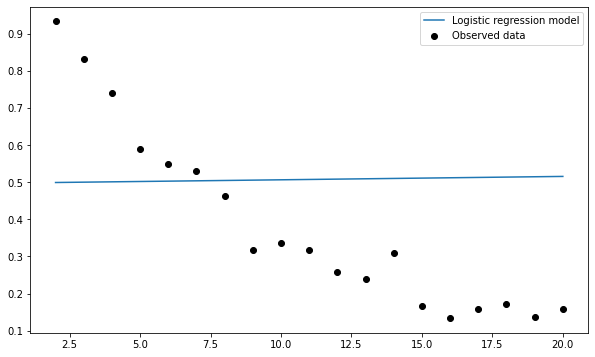

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(x_obs, obs, label="Observed data", color="black")
plt.plot(x_mod, mod_logistic, label="Logistic regression model")
plt.legend()
plt.show()

In [75]:
f_logistic_ds

functools.partial(<function f_logistic at 0x7feb2f799700>, a=<xarray.DataArray 'a' ()>
array(-0.01076966), b=<xarray.DataArray 'b' ()>
array(0.00364266))